# Test File 
This file was created to see how Coco annotations work and test dataloaders for CoCodataset\
Initial source: https://discuss.pytorch.org/t/how-to-efficiently-load-coco-dataset-to-dataloader/103380/2     
Note: Generative AI was used for coding assistance and debugging 


In [ ]:
#Imports
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.models.detection import faster_rcnn
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


In [ ]:

#dataset paths
data_dir = r"D:\UTN\GIT\g10\CoCo\train2017"
ann_file = r"D:\UTN\GIT\g10\CoCo\annotations\instances_train2017.json"

# Load COCO annotations and get ids
coco = COCO(ann_file)
image_ids = coco.getImgIds()
print(f"Loaded COCO dataset with {len(image_ids)} images.")


loading annotations into memory...
Done (t=12.84s)
creating index...
index created!
Loaded COCO dataset with 118287 images.


In [ ]:
def load_image_and_mask(image_id, coco, data_dir):
    """Loads an image and its corresponding segmentation mask from COCO dataset."""
    
    # Load image metadata
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(data_dir, image_info["file_name"])
    
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_info["id"])
    annotations = coco.loadAnns(ann_ids)

    # Create empty mask
    mask = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint8)

    # Convert polygon annotations to masks
    for ann in annotations:
        if 'segmentation' in ann:
            for segment in ann['segmentation']:
                poly = np.array(segment).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], color=1)

    return image, mask


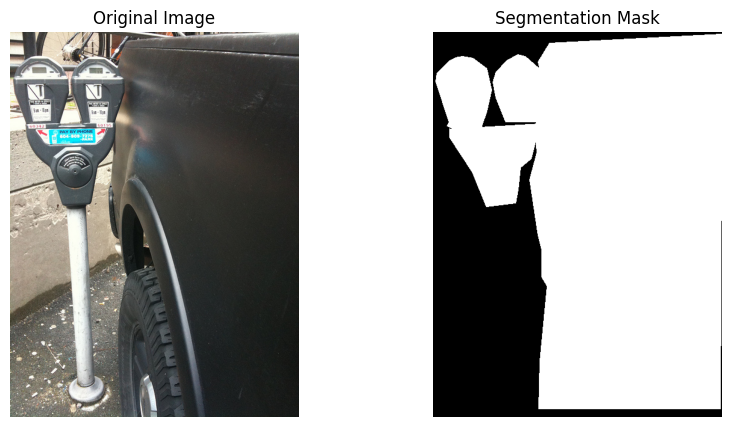

In [ ]:


# Select a random image
image_id = image_ids[1204]
image, mask = load_image_and_mask(image_id, coco, data_dir)

# Plot the image and its corresponding mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()


In [ ]:
def load_image_mask_labels(image_id, coco, data_dir):
    """Loads an image, its segmentation mask, and object labels from COCO dataset."""

    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(data_dir, image_info["file_name"])
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=image_info["id"])
    annotations = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint8)
    category_names = []  # Store object names
     
    for ann in annotations:
        if 'segmentation' in ann:
            for segment in ann['segmentation']:
                poly = np.array(segment).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], color=1)
                
            # Get category name
            category_id = ann["category_id"]
            category_name = coco.loadCats(category_id)[0]["name"]
            
            if category_name not in category_names:
                category_names.append(category_name)

    return image, mask, category_names

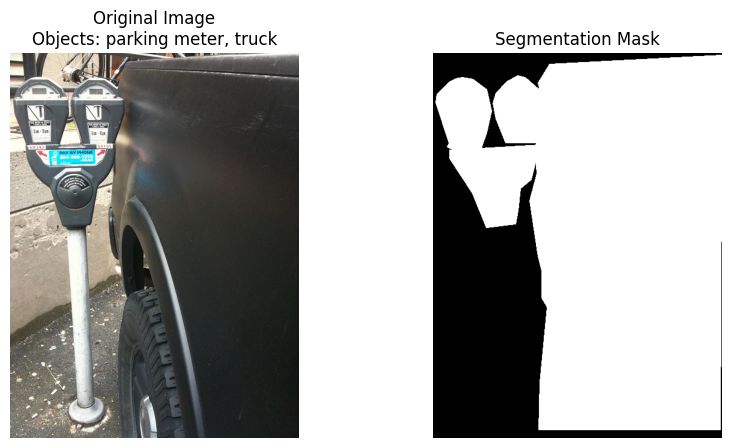

Objects in Image: ['parking meter', 'truck']


In [ ]:

# Select image by ID
image_id = image_ids[1204]
image, mask, category_names = load_image_mask_labels(image_id, coco, data_dir)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title(f"Original Image\nObjects: {', '.join(category_names)}")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()

#Objects in picture
print("Objects in Image:", category_names)


In [ ]:
def load_image_and_mask(image_id, coco, data_dir):
    """Loads an image and its corresponding multi-class segmentation mask."""
    
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(data_dir, image_info["file_name"])

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=image_info["id"])
    annotations = coco.loadAnns(ann_ids)

    # Create empty mask (initialized with background = 0)
    mask = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint8)

    # Convert polygon annotations to labeled masks
    for ann in annotations:
        category_id = ann["category_id"]  # Get category ID from COCO
        
        if 'segmentation' in ann:
            for segment in ann['segmentation']:
                poly = np.array(segment).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], color=category_id)  # Assign category ID

    return image, mask


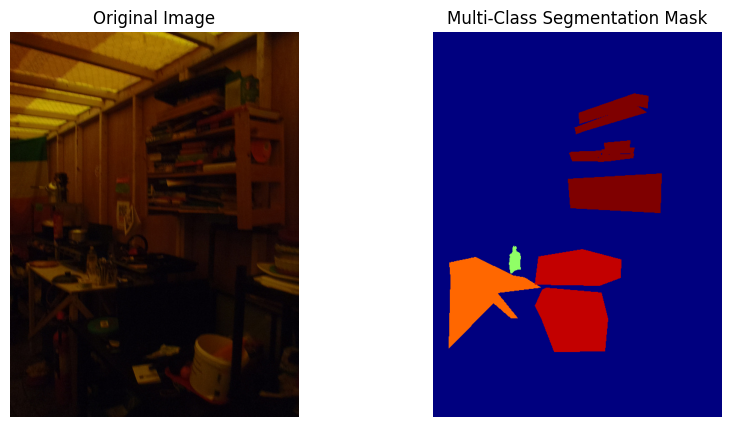

In [ ]:
# Select a random image
image_id = image_ids[10]
image, mask = load_image_and_mask(image_id, coco, data_dir)

# Display Image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Display Multi-Class Mask
ax[1].imshow(mask, cmap="jet")  
ax[1].set_title("Multi-Class Segmentation Mask")
ax[1].axis("off")

plt.show()

In [ ]:

def collate_fn(batch):
    images, targets = zip(*batch)
    images = [F.resize(image, (256, 256)) for image in images]  
    images = [F.to_tensor(image) for image in images]  
    images = torch.stack(images, dim=0)  
    return images, targets

In [ ]:

#transformation to match model input size
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))  #change according to loaded model's input size
])

data_dir = r"D:\UTN\GIT\g10\CoCo\train2017"  
annotation_file = r"D:\UTN\GIT\g10\CoCo\annotations\instances_train2017.json"  
coco_dataset = CocoDetection(root=data_dir, annFile=annotation_file, transform=transform)

# Create a DataLoader
# Then, pass this `collate_fn` to your DataLoader
dataloader = DataLoader(coco_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
# Example to check one batch of data
# for images, targets in dataloader:
#     print(images.shape)  # Tensor shape for the batch
#     print(targets)  # Ground truth targets (annotations)
#     break


loading annotations into memory...
Done (t=22.79s)
creating index...
index created!


In [ ]:

class CocoDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            ann_file (string): Path to the annotation file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())  # list of image ids
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.img_dir + '/' + img_info['file_name']
        image = Image.open(img_path).convert("RGB")
        
        # Get the annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        boxes = []
        labels = []
        
        for ann in anns:
            # Extract bounding boxes (x, y, width, height)
            bbox = ann['bbox']
            boxes.append([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])  # [xmin, ymin, xmax, ymax]
            # Extract label (category id)
            labels.append(ann['category_id'])
        
        # Convert to tensor
        boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.ids)

# Define a custom collate_fn to handle batching
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    
    # Targets are returned as a list of dictionaries
    return images, list(targets)

# Define the necessary transformations (optional)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to consistent size
    transforms.ToTensor()           # Convert to Tensor
])

# Path to your images and annotations
img_dir = r"D:\UTN\GIT\g10\CoCo\train2017"
ann_file = r"D:\UTN\GIT\g10\CoCo\annotations\instances_train2017.json"

# Create the dataset
coco_dataset = CocoDataset(img_dir=img_dir, ann_file=ann_file, transform=transform)

# Create DataLoader
dataloader = DataLoader(coco_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

# # Example to check one batch of data
# for images, targets in dataloader:
#     print(images.shape)  # Tensor shape for the batch
#     print(targets)  # Bounding boxes and labels for the batch
#     break


loading annotations into memory...
Done (t=17.45s)
creating index...
index created!


In [ ]:

def load_image_and_bounding_boxes(image_id, coco, data_dir):
    """
    Loads an image and its bounding boxes from the COCO dataset.

    Args:
        image_id (int): COCO image ID.
        coco (COCO): COCO object (from pycocotools).
        data_dir (str): Directory where images are stored.

    Returns:
        image (numpy array): The image with bounding boxes drawn on it.
        bounding_boxes (list): A list of bounding boxes as [xmin, ymin, xmax, ymax].
        category_names (list): A list of category names for the bounding boxes.
    """
    # Load image metadata
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(data_dir, image_info["file_name"])
    
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_info["id"])
    annotations = coco.loadAnns(ann_ids)
    
    bounding_boxes = []  # Store bounding boxes
    category_names = []  # Store object names

    # Draw bounding boxes and collect categories
    for ann in annotations:
        if 'bbox' in ann:
            # Bounding box format in COCO is [x, y, width, height]
            bbox = ann['bbox']
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            
            # Append bounding box and category name
            bounding_boxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            category_id = ann["category_id"]
            category_name = coco.loadCats(category_id)[0]["name"]
            
            # Draw the bounding box on the image
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=(255, 0, 0), thickness=2)
            
            # Add the category name to the image
            cv2.putText(image, category_name, (int(x_min), int(y_min) - 5), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, (255, 0, 0), 1, cv2.LINE_AA)

            if category_name not in category_names:
                category_names.append(category_name)

    return image, bounding_boxes, category_names


In [ ]:
from pycocotools.coco import COCO

annotation_file = r"D:\UTN\GIT\g10\CoCo\annotations\instances_train2017.json"
image_directory = r"D:\UTN\GIT\g10\CoCo\train2017"

coco = COCO(annotation_file)


loading annotations into memory...
Done (t=10.39s)
creating index...
index created!


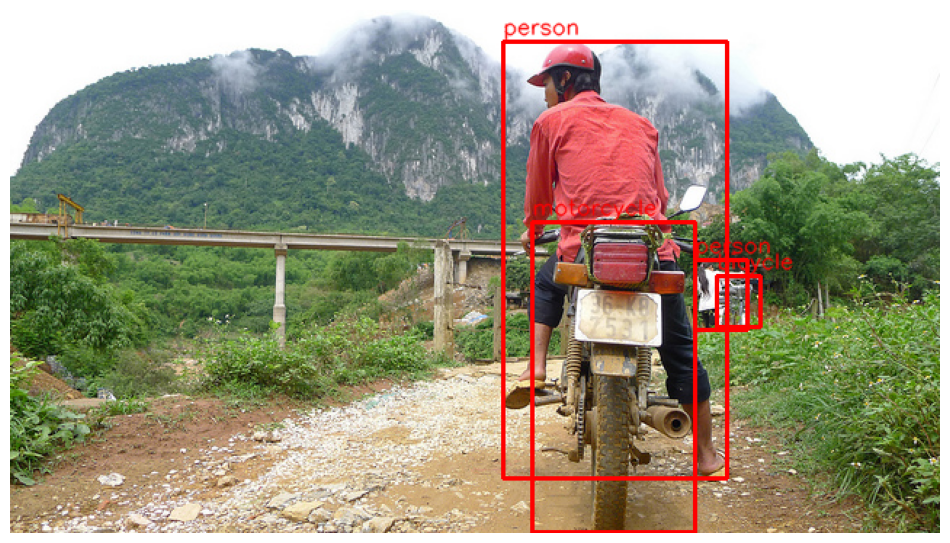

Bounding Boxes: [[359, 146, 471, 359], [339, 22, 493, 322], [471, 172, 507, 220], [486, 183, 516, 218]]
Categories: ['motorcycle', 'person', 'bicycle']


In [ ]:
import matplotlib.pyplot as plt

# Get a random image ID
image_id = coco.getImgIds()[0]

# Load the image and bounding boxes
image, bounding_boxes, category_names = load_image_and_bounding_boxes(image_id, coco, image_directory)

# Display the image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

# Print the bounding boxes and category names
print("Bounding Boxes:", bounding_boxes)
print("Categories:", category_names)


In [ ]:
import torch
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pycocotools.coco import COCO

class CustomCocoDataset(Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        """
        Args:
            img_dir (str): Directory with all images.
            ann_file (str): Path to COCO annotation JSON file.
            transform (callable, optional): Optional transformations to apply on images.
        """
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())  # List of image IDs
        self.transform = transform
        self.category_id_to_name = {cat["id"]: cat["name"] for cat in self.coco.loadCats(self.coco.getCatIds())}

    def __getitem__(self, index):
        """
        Loads an image, extracts bounding boxes and labels.
        Returns:
            image (Tensor): Transformed image.
            target (dict): Bounding boxes and labels.
        """
        # Get image ID and metadata
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info["file_name"])
        
        # Load the image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Load annotations (bounding boxes and category labels)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        
        boxes = []
        labels = []
        
        for ann in annotations:
            if "bbox" in ann:
                bbox = ann["bbox"]  # COCO format: [x, y, width, height]
                x_min, y_min, width, height = bbox
                x_max = x_min + width
                y_max = y_min + height
                boxes.append([x_min, y_min, x_max, y_max])  # Convert to [xmin, ymin, xmax, ymax]
                labels.append(ann["category_id"])  # Store category ID
            
        # Convert bounding boxes and labels to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels
        }

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.ids)


In [ ]:
def collate_fn(batch):
    """
    Custom collate function to handle images with different numbers of bounding boxes.
    Args:
        batch (list of tuples): List of (image, target) tuples.
    Returns:
        images (Tensor): Batch of images.
        targets (list of dicts): List of dictionaries containing bounding boxes and labels.
    """
    images, targets = zip(*batch)  # Unpack batch
    images = torch.stack(images, dim=0)  # Stack images into batch
    return images, list(targets)  # Return images and list of target dictionaries


In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV image to PIL
    transforms.Resize((512, 512)),  # Resize to standard size
    transforms.ToTensor()  # Convert to PyTorch tensor
])


In [ ]:
# Define paths
img_dir = r"D:\UTN\GIT\g10\CoCo\train2017"
ann_file = r"D:\UTN\GIT\g10\CoCo\annotations\instances_train2017.json"

# Create dataset
coco_dataset = CustomCocoDataset(img_dir=img_dir, ann_file=ann_file, transform=transform)

# Create DataLoader
dataloader = DataLoader(coco_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

# # Check a batch
# for images, targets in dataloader:
#     print(f"Batch image shape: {images.shape}")  # Expected: [8, 3, 512, 512]
#     print(f"Target example: {targets[0]}")  # Bounding boxes and labels
#     break


loading annotations into memory...
Done (t=13.46s)
creating index...
index created!


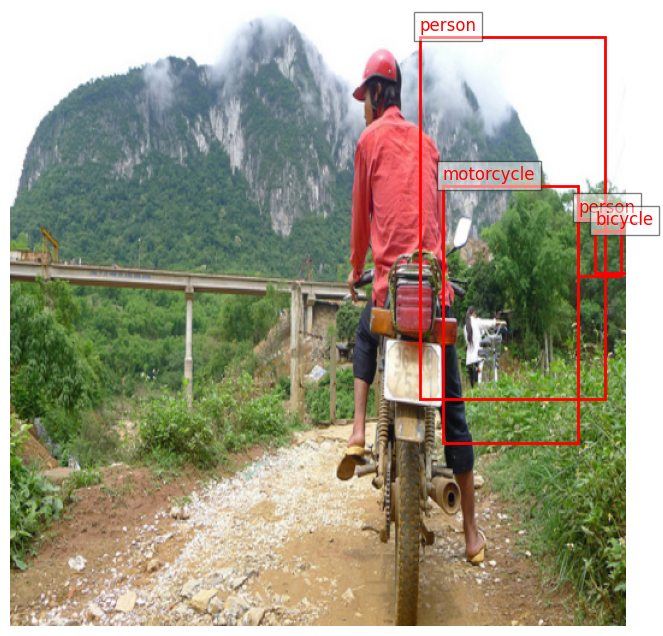

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(image, target, category_id_to_name):
    """
    Visualizes an image with bounding boxes.
    Args:
        image (Tensor): The image tensor.
        target (dict): The target dictionary containing 'boxes' and 'labels'.
        category_id_to_name (dict): Mapping of category IDs to category names.
    """
    image = image.permute(1, 2, 0).numpy()  # Convert [C, H, W] to [H, W, C]
    
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    boxes = target["boxes"]
    labels = target["labels"]
    
    for box, label in zip(boxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                  linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        
        class_name = category_id_to_name.get(label.item(), "Unknown")
        ax.text(x_min, y_min - 5, class_name, color="red", fontsize=12,
                bbox=dict(facecolor="white", alpha=0.5))
    
    plt.axis("off")
    plt.show()

# Visualize a sample image
image, target = coco_dataset[0]  # Get first image and target
visualize_sample(image, target, coco_dataset.category_id_to_name)


In [ ]:
import torch
import os
import cv2
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from torchvision import transforms
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        Args:
            img_dir (str): Directory with all images.
            transform (callable, optional): Optional transformations to apply on images.
        """
        self.img_dir = img_dir
        self.img_files = os.listdir(img_dir)  # List of image file names
        self.transform = transform

    def __getitem__(self, index):
        """
        Loads an image and applies transformations.
        Returns:
            image (Tensor): Transformed image.
        """
        # Get image file path
        img_file = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_file)
        
        # Load the image using OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image

    def __len__(self):
        return len(self.img_files)

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = CustomImageDataset(img_dir=r"D:\UTN\GIT\g10\CoCo\train2017", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# # Use the dataloader
# for images in dataloader:
#     print(images.shape)

In [ ]:
# Import necessary libraries
import torch
import random

# Use the dataloader to fetch a single batch
for images in dataloader:
    # images is a tensor of shape [batch_size, channels, height, width]
    batch_size = images.shape[0]
    
    # Pick 10 random indices from the batch
    random_indices = random.sample(range(batch_size), min(10, batch_size))
    
    # Select the random samples from the batch
    random_samples = images[random_indices]
    
    # Print the shapes of the selected samples
    print("Shapes of 10 random samples:")
    # for i, sample in enumerate(random_samples):
    #     print(f"Sample {i + 1}: {sample.shape}")
    
    # break  # Exit after processing one batch

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
Number of images in COCO validation set: 5000


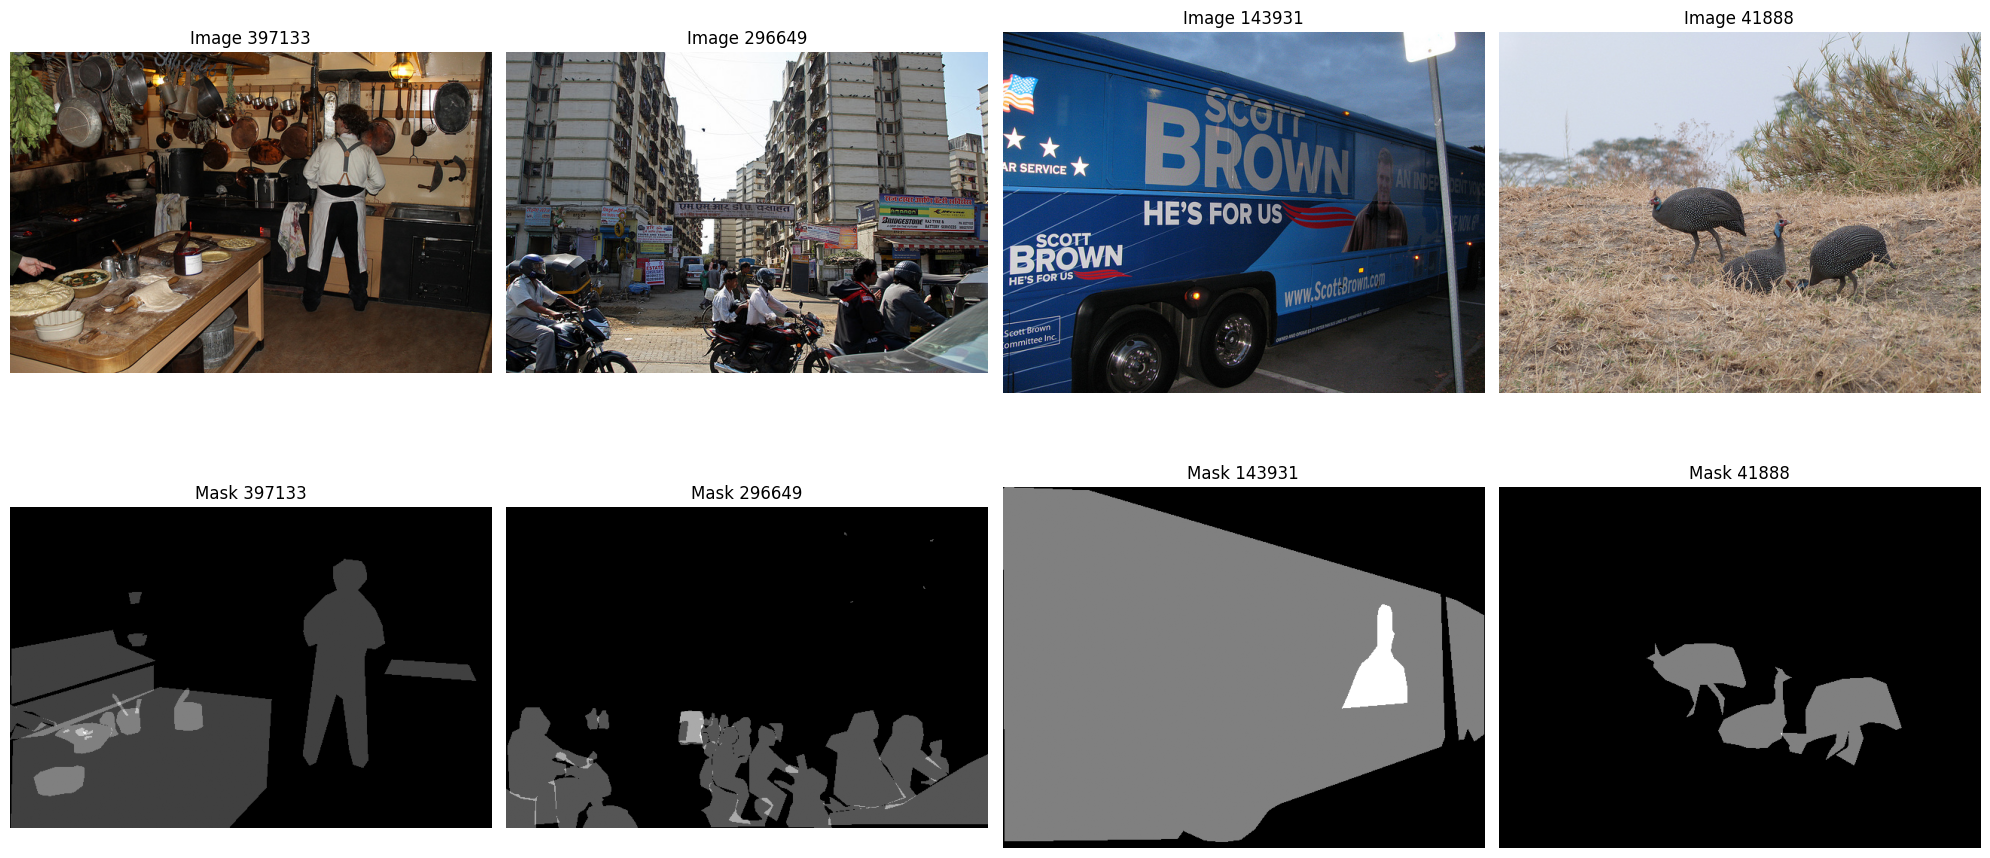

In [3]:
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# Define paths
coco_root = "/var/lit2425/pib/g10/CoCo"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"
coco_val_annotations = f"{coco_root}/annotations/instances_val2017.json"
coco_val_images = f"{coco_root}/val2017"

# Load COCO dataset annotations
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()

#Checking number of images in directory
print(f"Number of images in COCO validation set: {len(image_ids)}")

# Select 4 random image indices
selected_indices = [image_ids[0],image_ids[10],image_ids[20],image_ids[30]]  # You can modify this to select specific indices

# Display images and their masks
plt.figure(figsize=(20, 10))
for i, img_id in enumerate(selected_indices):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{coco_val_images}/{img_info['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Create mask
    mask = coco.annToMask(anns[0])  # Use the first annotation for simplicity
    for ann in anns[1:]:
        mask += coco.annToMask(ann)

    # Plot image and mask
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Image {img_id}")
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {img_id}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.colors as mcolors


# Define the output directory
output_dir = "/var/lit2425/pib/g10/test/result/cocoGT"  # Replace with your desired output folder path

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load COCO dataset annotations
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()

# Specify 4 image indices you want to download
selected_indices = [image_ids[0], image_ids[10], image_ids[20], image_ids[30]]  # Replace with your desired indices

# Define a color map for classes
# COCO has 80 classes, so we create a color for each class
num_classes = 80
colors = list(mcolors.TABLEAU_COLORS.values())  # Use Tableau colors for visualization
colors = [mcolors.to_rgb(color) for color in colors]  # Convert to RGB format
colors = [(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors]  # Scale to 0-255

# Loop through selected images
for i, img_id in enumerate(selected_indices):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{coco_val_images}/{img_info['file_name']}"
    img = cv2.imread(img_path)

    # Save the original image
    output_image_path = os.path.join(output_dir, f"image_{img_id}.jpg")
    cv2.imwrite(output_image_path, img)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Create an empty colored mask
    height, width = img.shape[:2]
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)  # 3 channels for RGB

    # Draw each annotation with its corresponding class color
    for ann in anns:
        class_id = ann["category_id"]  # Get the class ID
        mask = coco.annToMask(ann)  # Get the binary mask for this annotation
        color = colors[class_id % len(colors)]  # Assign a color based on class ID
        colored_mask[mask == 1] = color  # Apply the color to the mask

    # Save the colored mask
    output_mask_path = os.path.join(output_dir, f"colored_mask_{img_id}.png")
    cv2.imwrite(output_mask_path, colored_mask)

print(f"Images and colored masks saved to {output_dir}")

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Images and colored masks saved to /var/lit2425/pib/g10/test/result/cocoGT


loading annotations into memory...
Done (t=0.36s)
creating index...
index created!
Number of images in COCO validation set: 5000


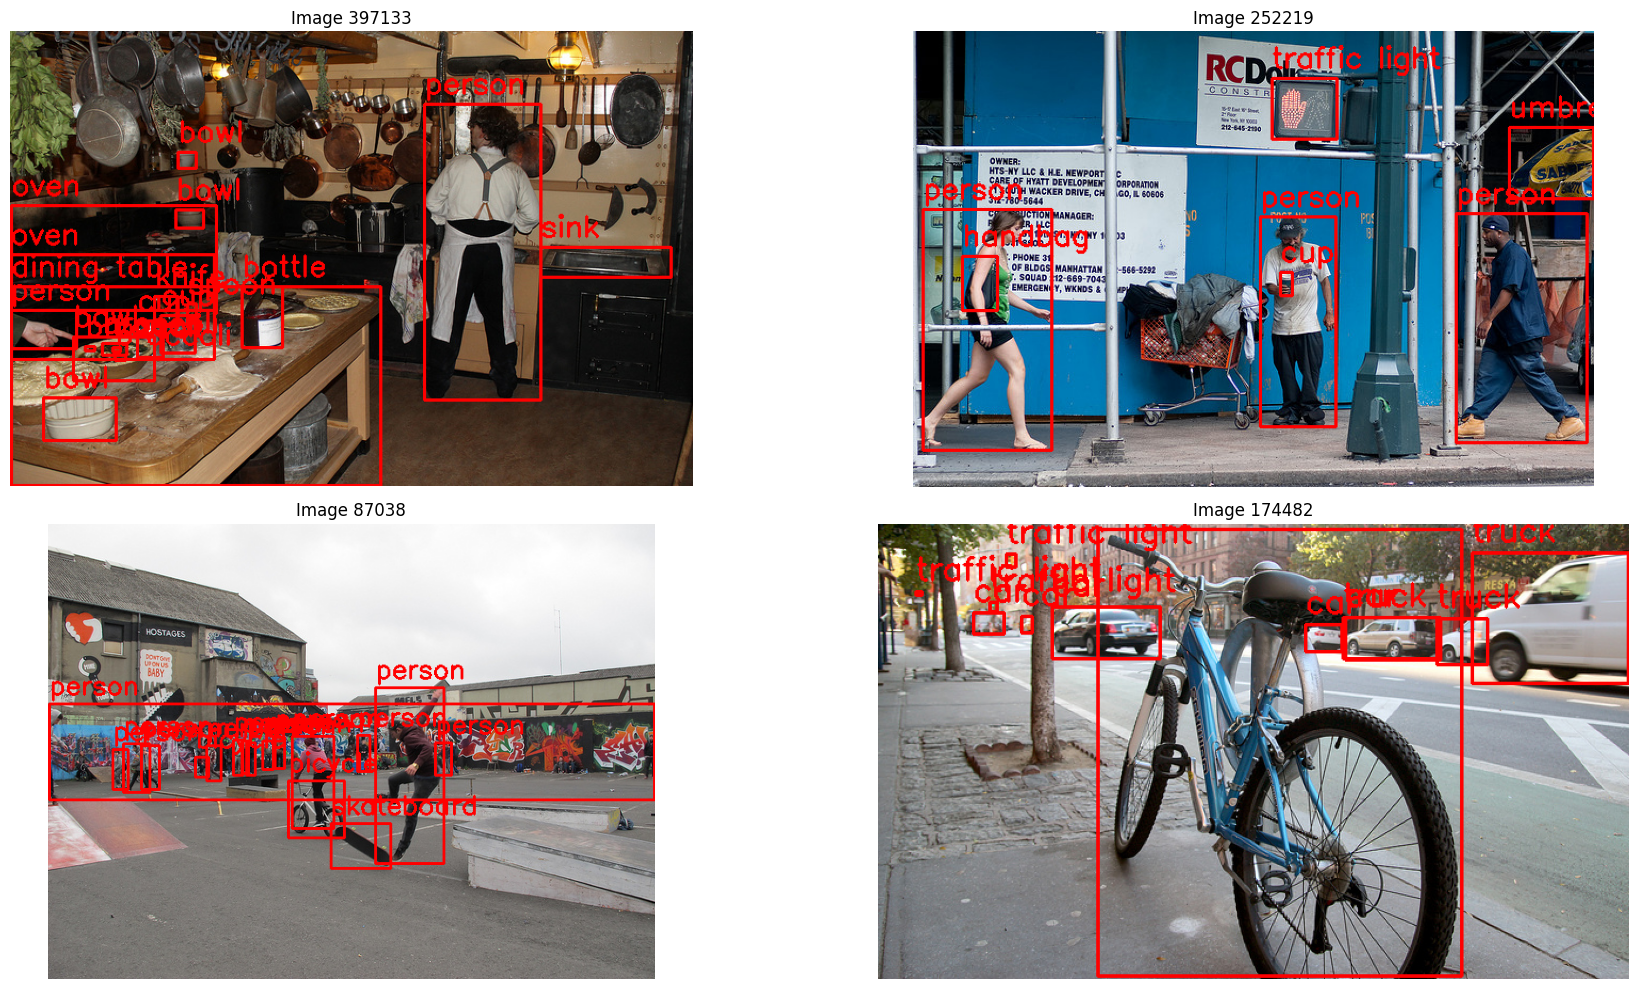

In [ ]:


# Define paths
coco_root = "/var/lit2425/pib/g10/CoCo"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"
coco_val_annotations = f"{coco_root}/annotations/instances_val2017.json"
coco_val_images = f"{coco_root}/val2017"

# Load COCO dataset annotations
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()

# Checking number of images in directory
print(f"Number of images in COCO validation set: {len(image_ids)}")

# Select 4 random image indices
selected_indices = [image_ids[0], image_ids[2], image_ids[3], image_ids[4]]  # You can modify this to select specific indices

# Display images with bounding boxes and object classes
plt.figure(figsize=(20, 10))
for i, img_id in enumerate(selected_indices):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{coco_val_images}/{img_info['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Draw bounding boxes and object classes
    for ann in anns:
        bbox = ann['bbox']
        x, y, w, h = map(int, bbox)  # Convert bbox coordinates to integers
        class_id = ann['category_id']
        class_name = coco.loadCats(class_id)[0]['name']

        # Draw bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Red color (BGR format)

        # Put class name above the bounding box
        cv2.putText(img, class_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot image with bounding boxes and class names
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Image {img_id}")
    plt.axis('off')

plt.tight_layout()
plt.show()

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Number of images in COCO validation set: 5000


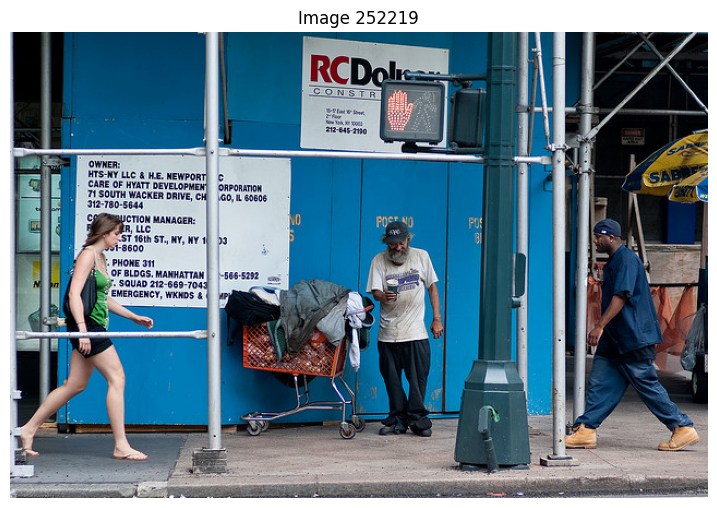

In [24]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO

# Define paths
coco_root = "/var/lit2425/pib/g10/CoCo"
coco_train_annotations = f"{coco_root}/annotations/instances_train2017.json"
coco_train_images = f"{coco_root}/train2017"
coco_val_annotations = f"{coco_root}/annotations/instances_val2017.json"
coco_val_images = f"{coco_root}/val2017"

# Load COCO dataset annotations
coco = COCO(coco_val_annotations)
image_ids = coco.getImgIds()

# Checking number of images in directory
print(f"Number of images in COCO validation set: {len(image_ids)}")

# Select 4 random image indices
selected_indices = [image_ids[2]]  # You can modify this to select specific indices

# Display images with bounding boxes and object classes
plt.figure(figsize=(20, 10))
for i, img_id in enumerate(selected_indices):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = f"{coco_val_images}/{img_info['file_name']}"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Create a matplotlib subplot
    ax = plt.subplot(2, 2, i + 1)
    ax.imshow(img)

    # Draw bounding boxes and object classes
    # for ann in anns:
    #     bbox = ann['bbox']
    #     x, y, w, h = map(int, bbox)  # Convert bbox coordinates to integers
    #     class_id = ann['category_id']
    #     class_name = coco.loadCats(class_id)[0]['name']

    #     # Draw bounding box using matplotlib
    #     rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor="red", facecolor="none")
    #     ax.add_patch(rect)

    #     # Add class name with transparent background
    #     ax.text(x, y - 5, class_name, color="red", fontsize=12,
    #             bbox=dict(facecolor="white", alpha=0.5))  # Adjust alpha for transparency

    # Set title and turn off axis
    ax.set_title(f"Image {img_id}")
    ax.axis('off')

plt.tight_layout()
plt.show()